# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [ ]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

import time
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV


from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [ ]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


**We observe that there are some issues with column 18, 19 for which warning has been displayed. We will take care of it afterwards. First, let's look into all the data provided.**

In [ ]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!
print (azdias.shape)
print (customers.shape)

(891221, 366)
(191652, 369)


**There are three extra columns in the customer dataset.**

In [ ]:
Extra_columns = []
for col in customers.columns:
    if col in azdias.columns:
        pass
    else:
        Extra_columns.append(col)
print (Extra_columns)

['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']


In [ ]:
customer_extra_cols = customers[Extra_columns].copy()
customer_extra_cols.head()

,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE
0,COSMETIC_AND_FOOD,MULTI_BUYER,0
1,FOOD,SINGLE_BUYER,0
2,COSMETIC_AND_FOOD,MULTI_BUYER,0
3,COSMETIC,MULTI_BUYER,0
4,FOOD,MULTI_BUYER,0


**Also, there are two Excel sheets provided with information and values of the attributes column in both azdias file as welll as customers file. This will help understand the data.**

In [ ]:
attri_info = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header=1)
attri_info.head()

,Attribute,Description,Value,Meaning
NaN,AGER_TYP,best-ager typology,-1,unknown
NaN,NaN,NaN,0,no classification possible
NaN,NaN,NaN,1,passive elderly
NaN,NaN,NaN,2,cultural elderly
NaN,NaN,NaN,3,experience-driven elderly


In [ ]:
attri_values = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header=1)
attri_values.head()

,Attribute,Description,Value,Meaning
NaN,AGER_TYP,best-ager typology,-1,unknown
NaN,NaN,NaN,0,no classification possible
NaN,NaN,NaN,1,passive elderly
NaN,NaN,NaN,2,cultural elderly
NaN,NaN,NaN,3,experience-driven elderly


**We can use Forward Fill method to fill Nan values in Attribute column**

In [ ]:
attri_values['Attribute'] = attri_values['Attribute'].ffill()
attri_values.head()

,Attribute,Description,Value,Meaning
NaN,AGER_TYP,best-ager typology,-1,unknown
NaN,AGER_TYP,NaN,0,no classification possible
NaN,AGER_TYP,NaN,1,passive elderly
NaN,AGER_TYP,NaN,2,cultural elderly
NaN,AGER_TYP,NaN,3,experience-driven elderly


# **Let's take care of the Warnings Columns first**

In [ ]:
Warning_Cols = customers.columns[18:20]
customers[Warning_Cols].head()

,CAMEO_DEUG_2015,CAMEO_INTL_2015
0,1,13
1,NaN,NaN
2,5,34
3,4,24
4,7,41


**Looking at the excel data for the attributes values, we can establish that the values are categorical with integer values provided for each category**

In [ ]:
print(azdias[Warning_Cols[0]].unique())
print('\n')
print(azdias[Warning_Cols[1]].unique())

[nan 8.0 4.0 2.0 6.0 1.0 9.0 5.0 7.0 3.0 '4' '3' '7' '2' '8' '9' '6' '5'
 '1' 'X']


[nan 51.0 24.0 12.0 43.0 54.0 22.0 14.0 13.0 15.0 33.0 41.0 34.0 55.0 25.0
 23.0 31.0 52.0 35.0 45.0 44.0 32.0 '22' '24' '41' '12' '54' '51' '44' '35'
 '23' '25' '14' '34' '52' '55' '31' '32' '15' '13' '43' '33' '45' 'XX']


**Both the dataset has mixed data type in the columns 18 and 19. We can see that we have 5 kinds of values viz. 'X', 'XX', 'nan', 'floats', 'strings'. Since as per the Attributes Data, -1 is the value assigned to unknown values, we can replace 'X', 'XX' values with nan and convert the types of rest of the values to floats. This will hopefully solve our warning issues.**

In [ ]:
def clear_warn(data):
    '''This function will help clean the coilumns as per the Warnings while loading the dataset.
    
    Input: 

    data: dataset(azdias / customers)
    
    Output:
    Cleans data
    '''
    Warning_Cols = data.columns[18:20]
    cols = Warning_Cols
    data[cols] = data[cols].replace({'X': np.nan, 'XX': np.nan})
    data[cols] = data[cols].astype(float)
    
    return data  

In [ ]:
azdias = clear_warn(azdias)
customers = clear_warn(customers)

# **Let's Start Data Cleaning**

**The columns LP_FAMILIE_FEIN, LP_FAMILIE_GROB, LP_LEBENSPHASE_GROB contains 0 as a value which does not correspond to any category as the per the values information given in Attributes Values File. For this reason, any value which is 0 in these columns needs to be converted to nan.**

In [ ]:
print(azdias.LP_FAMILIE_FEIN.unique())
print(azdias.LP_FAMILIE_GROB.unique())
print(azdias.LP_STATUS_GROB.unique())
print(azdias.LP_LEBENSPHASE_GROB.unique())
print(azdias.LP_LEBENSPHASE_FEIN.unique())
print(azdias.LP_STATUS_FEIN.unique())

[  2.   5.   1.   0.  10.   7.  11.   3.   8.   4.   6.  nan   9.]
[  2.   3.   1.   0.   5.   4.  nan]
[  1.   2.   4.   5.   3.  nan]
[  4.   6.   1.   0.  10.   2.   3.   5.   7.  12.  11.   9.   8.  nan]
[ 15.  21.   3.   0.  32.   8.   2.   5.  10.   4.   6.  23.  12.  20.   1.
  11.  25.  13.   7.  18.  31.  19.  38.  35.  30.  22.  14.  33.  29.  24.
  28.  37.  26.  39.  27.  36.   9.  34.  nan  40.  16.  17.]
[  1.   2.   3.   9.   4.  10.   5.   8.   6.   7.  nan]


**Also, in these columns there is a lot of information that can be compressed, which is done by the following function.**


In [ ]:
def fix_LP_cols(df):
    """
    Function to replace 0s with nan values columns,
    ["LP_FAMILIE_FEIN", "LP_FAMILIE_GROB", "LP_LEBENSPHASE_FEIN",
           "LP_LEBENSPHASE_GROB", "LP_STATUS_FEIN", "LP_STATUS_GROB"]
    """
    
    # Replacing '0' with NaNs
    cols = ["LP_FAMILIE_FEIN", "LP_FAMILIE_GROB", "LP_LEBENSPHASE_FEIN",
           "LP_LEBENSPHASE_GROB", "LP_STATUS_FEIN", "LP_STATUS_GROB"]
    
    df[cols] = df[cols].replace({0: np.nan})
    df[cols] = df[cols].astype(float)
    
    
    
    # LP_FAMILIE_GROB
    convert_1 = {1: 'single', 2: 'couple', 3: 'singleparent', 4: 'singleparent', 5: 'singleparent', 
                  6: 'family', 7: 'family', 8: 'family', 9: 'multihousehold', 10: 'multihousehold', 11: 'multihousehold'}
    convert_2 = {'single':0, 'couple':1, 'singleparent':2, 'family':3, 'multihousehold':4}
    
    df["LP_FAMILIE_GROB"] = df["LP_FAMILIE_GROB"].map(convert_1)
    df["LP_FAMILIE_GROB"] = df["LP_FAMILIE_GROB"].map(convert_2)
    
    # LP_STATUS_GROB    
    convert_1 = {1: 'lowincome', 2: 'lowincome', 3: 'avgincome', 4: 'avgincome', 5: 'avgincome', 
                  6: 'independant', 7: 'independant', 8: 'houseowner', 9: 'houseowner', 10: 'topearner'}
    convert_2 = {'lowincome':0, 'avgincome':1, 'independant':2, 'houseowner':3, 'topearner':4}
    
    df["LP_STATUS_GROB"] = df["LP_STATUS_GROB"].map(convert_1)
    df["LP_STATUS_GROB"] = df["LP_STATUS_GROB"].map(convert_2)
    
    
    # LP_LEBENSPHASE_FEIN
    life_stages = {1: 'younger_age', 2: 'middle_age', 3: 'younger_age',
              4: 'middle_age', 5: 'advanced_age', 6: 'retirement_age',
              7: 'advanced_age', 8: 'retirement_age', 9: 'middle_age',
              10: 'middle_age', 11: 'advanced_age', 12: 'retirement_age',
              13: 'advanced_age', 14: 'younger_age', 15: 'advanced_age',
              16: 'advanced_age', 17: 'middle_age', 18: 'younger_age',
              19: 'advanced_age', 20: 'advanced_age', 21: 'middle_age',
              22: 'middle_age', 23: 'middle_age', 24: 'middle_age',
              25: 'middle_age', 26: 'middle_age', 27: 'middle_age',
              28: 'middle_age', 29: 'younger_age', 30: 'younger_age',
              31: 'advanced_age', 32: 'advanced_age', 33: 'younger_age',
              34: 'younger_age', 35: 'younger_age', 36: 'advanced_age',
              37: 'advanced_age', 38: 'retirement_age', 39: 'middle_age',
              40: 'retirement_age'}

    wealth_scale = {1: 'low', 2: 'low', 3: 'average', 4: 'average', 5: 'low', 6: 'low',
              7: 'average', 8: 'average', 9: 'average', 10: 'wealthy', 11: 'average',
              12: 'average', 13: 'top', 14: 'average', 15: 'low', 16: 'average',
              17: 'average', 18: 'wealthy', 19: 'wealthy', 20: 'top', 21: 'low',
              22: 'average', 23: 'wealthy', 24: 'low', 25: 'average', 26: 'average',
              27: 'average', 28: 'top', 29: 'low', 30: 'average', 31: 'low',
              32: 'average', 33: 'average', 34: 'average', 35: 'top', 36: 'average',
              37: 'average', 38: 'average', 39: 'top', 40: 'top'}
    
    df["Temp"] = df["LP_LEBENSPHASE_FEIN"]
    
    df["LP_LEBENSPHASE_FEIN"] = df["LP_LEBENSPHASE_FEIN"].map(life_stages)
    df["LP_LEBENSPHASE_GROB"] = df["Temp"].map(wealth_scale)
    
    life_stages = {'younger_age': 1, 'middle_age': 2, 'advanced_age': 3,
            'retirement_age': 4}
    wealth_scale = {'low': 1, 'average': 2, 'wealthy': 3, 'top': 4}
    
    df["LP_LEBENSPHASE_FEIN"] = df["LP_LEBENSPHASE_FEIN"].map(life_stages)
    df["LP_LEBENSPHASE_GROB"] = df["LP_LEBENSPHASE_GROB"].map(wealth_scale)
        

    return df

In [ ]:
azdias = fix_LP_cols(azdias)
customers = fix_LP_cols(customers)

**It is important to note that most of the unknown values in the datset have been mapped either as -1, 0 or 9. First, we need to map these values to np.nan to get the actual number of Null Values**

In [ ]:
unknown_attri_values = attri_values[attri_values['Meaning'] == 'unknown']
unknown_attri_values.head(5)

,Attribute,Description,Value,Meaning
NaN,AGER_TYP,best-ager typology,-1,unknown
NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
NaN,ANREDE_KZ,gender,"-1, 0",unknown
NaN,BALLRAUM,distance to next urban centre,-1,unknown
NaN,BIP_FLAG,business-flag indicating companies in the buil...,-1,unknown


In [ ]:
unknown_attri_values['Value'] = unknown_attri_values['Value'].astype(str).str.split(",")
unknown_attri_values.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Attribute,Description,Value,Meaning
NaN,AGER_TYP,best-ager typology,[-1],unknown
NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,"[-1, 0]",unknown
NaN,ANREDE_KZ,gender,"[-1, 0]",unknown
NaN,BALLRAUM,distance to next urban centre,[-1],unknown
NaN,BIP_FLAG,business-flag indicating companies in the buil...,[-1],unknown


In [ ]:
#Creating a function to return the different unknown values per attribute in a iterable format
def to_flatten(my_list, primitives=(bool, str, int, float)):
    flatten = [] #This list will hold the string values with whitespace in the left
    for item in my_list:
        if isinstance(item, primitives):
            flatten.append(item)
        else:
            flatten.extend(item)
    unknown = [] #We will remove the whitespace and convert it to int
    for values in flatten:
        value = int(values.lstrip())
        unknown.append(value)
    unknown = list(set(unknown)) #to count only unique values
    return unknown

def get_unknown(attribute, unknown_attri_values):
    
    my_list = unknown_attri_values[unknown_attri_values['Attribute'] == attribute]['Value'].values
    unknown = to_flatten(my_list)
    
    return unknown

In [ ]:
#Creating a function to convert the unknown values from the dataset with NaN

def replace_with_nan(x):
    '''Replace the unknown values to nan'''
    try:
        if x in unknown:
            return np.nan
        else:
            return x
    except:
        return x

In [ ]:
#Replacing the unknown values in the dataset to NaN values
def replace_unknown(df, unknown_attri_values):
    """
    Replaces unknown values to 'np.nan' in all the columns common to both unkown_attri_values 
    as well as azdias/customer dataset.
    """
    for attribute in unknown_attri_values.Attribute:
        unknown = get_unknown(attribute, unknown_attri_values)
        if attribute in df.columns:
            df[attribute] = df[attribute].apply(replace_with_nan)
    return df

In [ ]:
azdias = replace_unknown(azdias, unknown_attri_values)
customers = replace_unknown(customers, unknown_attri_values)

**Before cleaning for the Nan Values we can observe that we still have some columns in each DataSet with object as dtypes. We need to take care of it first.**

In [ ]:
azdias.select_dtypes('object').head()

,CAMEO_DEU_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN
1,8A,NaN,1992-02-10 00:00:00,W
2,4C,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,D19_SCHUHE,1992-02-12 00:00:00,W


In [ ]:
attri_values[attri_values['Attribute'] == 'CAMEO_DEU_2015'].head()

,Attribute,Description,Value,Meaning
NaN,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,1A,Work-Life-Balance
NaN,CAMEO_DEU_2015,NaN,1B,Wealthy Best Ager
NaN,CAMEO_DEU_2015,NaN,1C,Successful Songwriter
NaN,CAMEO_DEU_2015,NaN,1D,Old Nobility
NaN,CAMEO_DEU_2015,NaN,1E,City Nobility


In [ ]:
attri_values[attri_values['Attribute'] == 'OST_WEST_KZ']

,Attribute,Description,Value,Meaning
NaN,OST_WEST_KZ,flag indicating the former GDR/FRG,-1,unknown
NaN,OST_WEST_KZ,NaN,O,East (GDR)
NaN,OST_WEST_KZ,NaN,W,West (FRG)


**The CAMEO_DEU_2015 column contains information as "New German CAMEO Typology established together with Call Credit in late 2015". We can map the values as defined in Attribute list in the function below**

In [ ]:
def fix_cam_deu(df):
    
    '''Creating function to fix the CAMEO_DEU_2015 column by maping the proper values for Attributes file
    with the values in the column'''

    dict_1 = dict(list(enumerate(df['CAMEO_DEU_2015'].unique())))

    dict_2 = dict([(value, key) for key, value in dict_1.items()])
    
    convert = dict_2
    df['CAMEO_DEU_2015'] = df['CAMEO_DEU_2015'].map(convert)
    
    df['CAMEO_DEU_2015'] = df['CAMEO_DEU_2015'].replace({0: np.nan, 45: np.nan}) 
    
    return df

In [ ]:
azdias = fix_cam_deu(azdias)
customers = fix_cam_deu(customers)

**Now let's take care of OST_WEST_KZ. As per the Attributes Info "flag indicating the former GDR/FRG". We will map the values as defined in the Attributes Values file with the help of the following function**

In [ ]:
def fix_OST(df):
    '''Creating function to fix the OST_WEST_KZ column by maping the proper values for Attributes file
    with the values in the column'''
    
    convert = {-1: np.nan, 'O': 1, 'W': 0}
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map(convert)
    
    return df

In [ ]:
azdias = fix_OST(azdias)
customers = fix_OST(customers)

**There is no information available regarding the 'D19_LETZTER_KAUF_BRANCHE' column. Further inspection suggest that the column has values of 'The last purchase branch'. We can safely drop the column as such.**

In [ ]:
azdias.drop('D19_LETZTER_KAUF_BRANCHE', axis = 1, inplace = True)
customers.drop('D19_LETZTER_KAUF_BRANCHE', axis = 1, inplace = True)

**EINGEFUEGT_AM Columns seems to be a datetime column which is mapped as object. We need to convert it into datetime and pick the year from the values.**

In [ ]:
def fix_EINGEFUEFGT(df):
    
    '''Creating function to fix the EINGEFUEGT_AM column by coverting the values in the column to datetime format and then picking
    Year from the same. The new column will contain only the Year'''

    df['EINGEFUEGT_AM'] = pd.to_datetime(df['EINGEFUEGT_AM'], infer_datetime_format=True)
    df['EINGEFUEGT_AM'] = pd.DatetimeIndex(df['EINGEFUEGT_AM']).year
    
    return df

In [ ]:
azdias = fix_EINGEFUEFGT(azdias)
customers = fix_EINGEFUEFGT(customers)

**ANDRE_KZ atttributes contain category as Male and Female with coding 1 and 2 respectively. We can map the values as 0 and 1 for ease in standardizing**

In [ ]:
def fix_ANDREDE(df):
    '''Creating a function to map the values of ANDRE_KZ column to 0, 1'''

    df['ANREDE_KZ'] = df['ANREDE_KZ'].replace({1: 0, 2: 1})
    
    return df

In [ ]:
azdias = fix_ANDREDE(azdias)
customers = fix_ANDREDE(customers)

**We have 0 as a value in WOHNLAGE which can be mapped to NaN.**

In [ ]:
def fix_WOHNLAGE(df):
    '''Fixing WOHNLAGE by replacing 0 with NaN'''
    convert = {0: np.nan}
    
    df['WOHNLAGE'] = df['WOHNLAGE'].replace({0: np.nan})
    
    return df
    

In [ ]:
azdias = fix_WOHNLAGE(azdias)
customers = fix_WOHNLAGE(customers)

**Further LNR is id of the people, not the feature itself which needs to be dropped**

In [ ]:
azdias = azdias.drop("LNR", axis=1)
customers = customers.drop("LNR", axis=1)

# **Attacking Missing Values**

**Let's try and fix missing values. First we will look at the percentage of Null Values in the columns where percentage is more than 30% and will drop those columns as not much information can be gained.**

In [ ]:
def get_missing_perc(df):
    '''Creating a datframe with missing percentage for each attribute columns. 
    '''
    missing_perc = df.isna().sum() * 100 / len(df)
    missing_perc_df = pd.DataFrame({"Attribute": df.columns,
                                  "Missing Percent": missing_perc}).reset_index(drop = True)
    return missing_perc_df

In [ ]:
azd_miss_report = get_missing_perc(azdias)
cust_miss_report = get_missing_perc(customers)

In [ ]:
#Let's plot the percentage to have a better understanding
def plot_percentage_missing(df1, df2, percentage=0, figsize=(10,70)):
    """
    Takes in two dataframes and plots a barchart comparing two dataframes
    features and percentage of missing values based on a threshold percentage given
    """
    fig = plt.figure(figsize=figsize)

    fig.suptitle("Missing Data percentages")

    ax = fig.add_subplot(121)
    ax.set_title("Azdias")
    sns.barplot(y="Attribute", x="Missing Percent", 
                data=df1[df1["Missing Percent"]>percentage], ax= ax)

    ax = fig.add_subplot(122)
    ax.set_title("Customer")
    sns.barplot(y="Attribute", x="Missing Percent", 
                data=df2[df2["Missing Percent"]>percentage], ax= ax)

    fig.tight_layout(rect=[0, 0.03, 1, 0.975])
    plt.show()


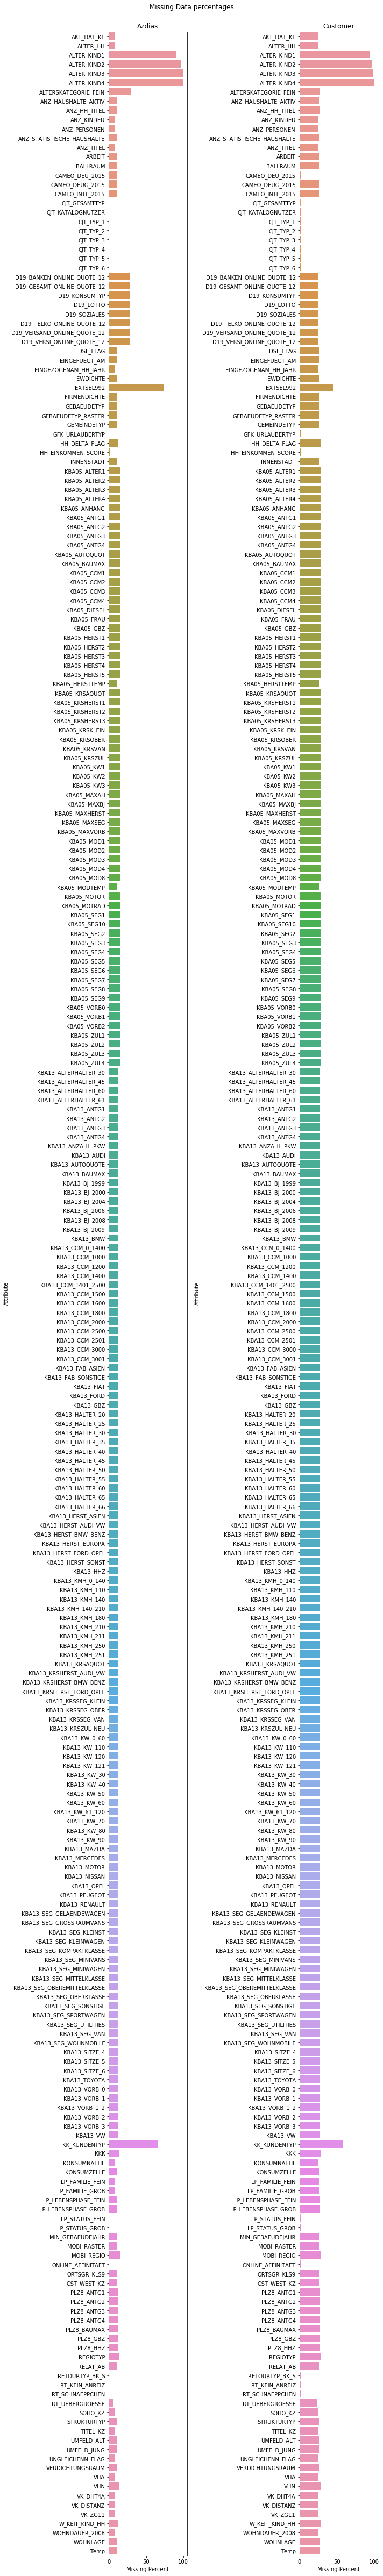

In [ ]:
plot_percentage_missing(azd_miss_report, cust_miss_report, percentage=0)

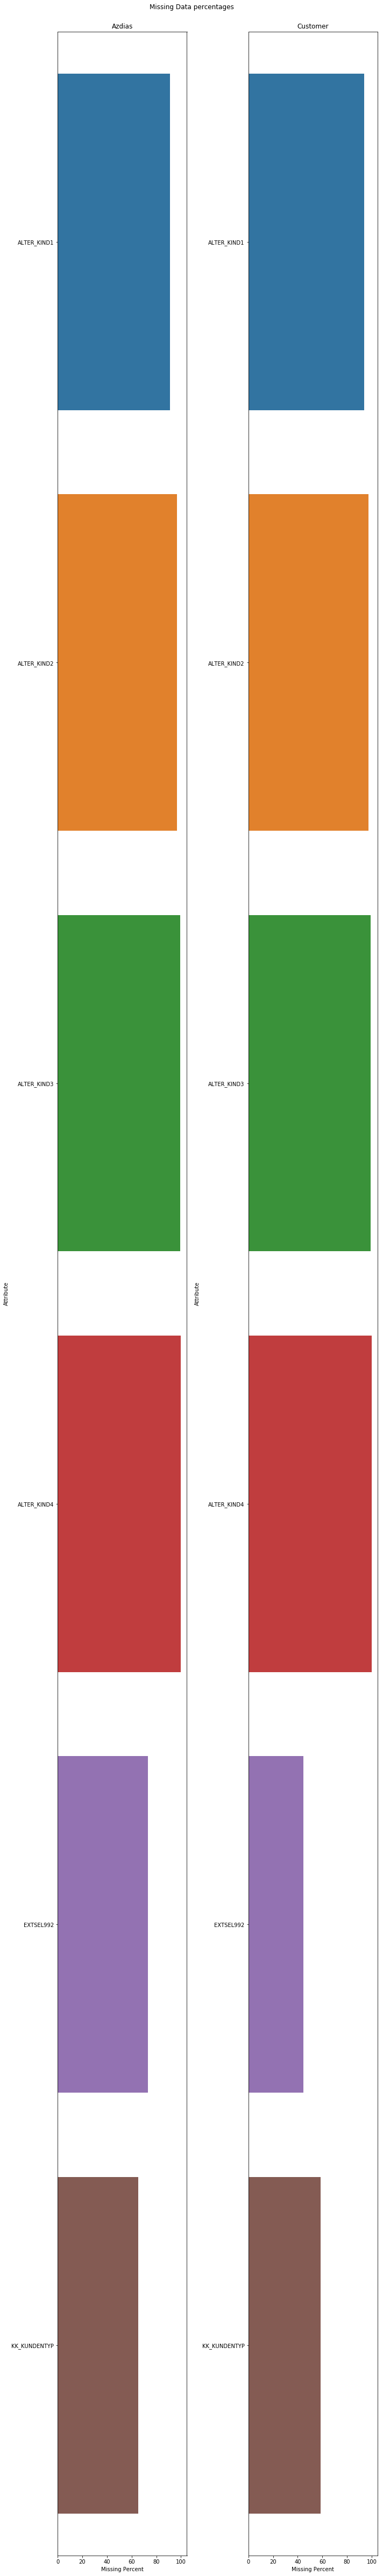

In [ ]:
plot_percentage_missing(azd_miss_report, cust_miss_report, percentage=30)

**From above, it looks like 6 columns in our cleaned datset have missing values more than 40%. We may choose to drop these columns with missing values more than 40% as not much of the information can be retrieved**

In [ ]:
missing_cols = azd_miss_report[azd_miss_report['Missing Percent'] >= 30].Attribute.tolist()
azdias.drop(missing_cols, axis = 1, inplace = True)
customers.drop(missing_cols, axis = 1, inplace = True)

**Let's look at the missing values row wise.**

In [ ]:
def plot_missing_row_wise(df1, df2, bins=30, figsize=(10,6)):
    """
    Takes in two dataframes and plots a barchart comparing two dataframes
    rows and percentage of missing values based on a threshold percentage given
    """
    bins = 30
    fig = plt.figure(figsize=figsize)

    ax = fig.add_subplot(111)
    ax.set_title("No. of Missing features Row-wise")
    ax.set_xlabel("No. of Missing Features")
    ax.set_ylabel("No. of Rows")
    sns.distplot(df1.isnull().sum(axis=1), bins, kde=False, ax=ax, label="Azdias")
    sns.distplot(df2.isnull().sum(axis=1), bins, kde=False, ax=ax, label="Customers")
    ax.legend()
    
    plt.show()



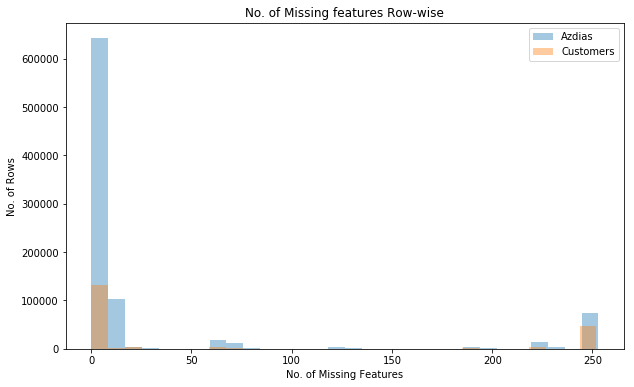

In [ ]:
plot_missing_row_wise(azdias, customers);

**We will delete the rows with Null values more than 50 as they will not help us in analysis**

In [ ]:
def remove_missing_rows(df, threshold, name=""):
    """
    Takes in a dataframe and drops rows with number of missing features 
    as per given threshold.
    """

    df = df.dropna(thresh=df.shape[1]-threshold)
    
    # Reset index
    df = df.reset_index()
    del df['index']
    
    return df

In [ ]:
azdias = remove_missing_rows(azdias, threshold = 50)
customers = remove_missing_rows(customers, threshold = 50)

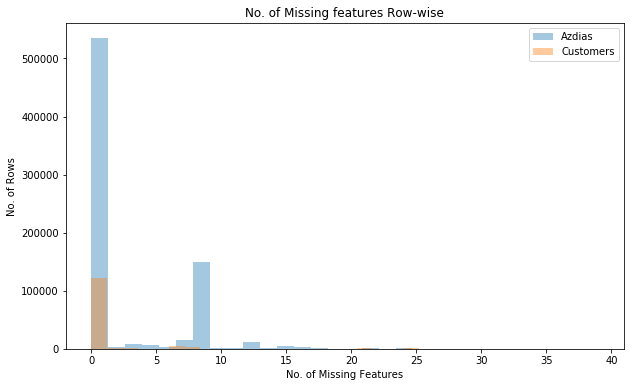

In [ ]:
plot_missing_row_wise(azdias, customers)

In [ ]:
print (azdias.shape)
print ('\n')
print (customers.shape)

(751331, 359)


(135144, 362)


**Let's seperate the extra columns from the customers dataset by creating a new dataset.**

In [ ]:
customers = customers.drop(Extra_columns, axis = 1)

**Now we need to Impute the NaN values in our dataset. We understand the data present is demographic data of the people. It makes sense to fill the NaN values with the most common data available in each Attributes columns.**

In [ ]:
#from sklearn.impute import SimpleImputer
#imputer = SimpleImputer(strategy = "most_frequent")

In [ ]:
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy = "most_frequent")

**Since our Training data comes from azdias, we will fit_transform the azdias and only transform the customers dataset.**

In [ ]:
azdias = pd.DataFrame(imputer.fit_transform(azdias), columns = azdias.columns)
customers = pd.DataFrame(imputer.transform(customers), columns = customers.columns)

**We will scale our data,so as to make sure our all our features remain in the same range**

In [ ]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()

azdias = pd.DataFrame(scale.fit_transform(azdias), columns = azdias.columns)
customers = pd.DataFrame(scale.transform(customers), columns = customers.columns) 

**We will save the cleaned dataset so that it can be loaded easily for further analysis**

In [ ]:
#azdias.to_csv("azdias_cleaned", index = False)
#customers.to_csv("customers_cleaned", index = False)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

**We can see that we have too many features for performing analysis. However not all features are important. To choose the important features, we can try dimensionality reduction technique using PCA**

In [ ]:
pca = PCA()

In [ ]:
azdias_pca = pca.fit(azdias) #Fitting our data to PCA
azdias_pca.explained_variance_ratio_[0:11]#Top 10 features nearly explains 36% of the data

array([ 0.08271059,  0.07276108,  0.05194873,  0.0454953 ,  0.03888909,
        0.02263044,  0.01970299,  0.01679212,  0.01524919,  0.01413542,
        0.01231631])

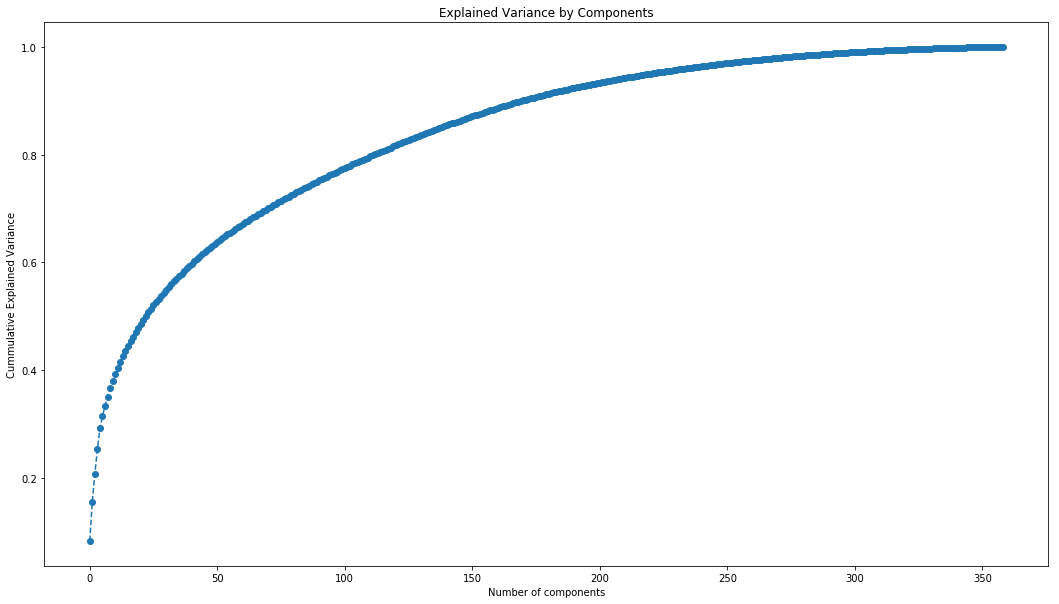

In [ ]:
#Let's try to find the number of essential features using the PCA plot of ratio of Variance and number of features
#Plot to find the optimal number of features which will explain atleast 80% of our data
plt.figure(figsize = (18, 10))
plt.plot(range(len(azdias.columns)), azdias_pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--' )
plt.xlabel('Number of components')
plt.ylabel('Cummulative Explained Variance')
plt.title('Explained Variance by Components')
plt.show()

**From the graph we observe that 120 components are enough to explain 80% variability in the data.**

In [ ]:
pca_120 = PCA(n_components = 120) #We will choose 120 as number of components

In [ ]:
pca_120.fit(azdias)
azdias_pca_120 = pca_120.transform(azdias)

**Let's now run KMeans for specifying the clusters in which we group our data**

In [ ]:
#Let's start with determining the number of clusters needed
wcss = []  #Empty list of sum of squared distance of data points within each cluster
for i in range(2, 22, 2): #running the loop ten times to find the optimal number of clusters
  kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 101) #k-means++ will initialize a seed for cluster centroid 
  kmeans.fit(azdias_pca_120)
  wcss.append(kmeans.inertia_) #kmeans.inertia_ will provide the sum of squared distance of each data component from the cluster centroid

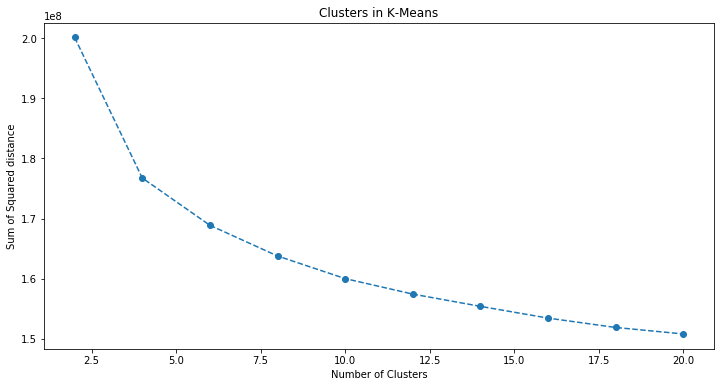

In [ ]:
#The next step involves plotting the WCSS against the number of components on a graph. 
plt.figure(figsize = (12, 6))
plt.plot(range(2, 22, 2), wcss, marker = 'o', linestyle = '--')
plt.title('Clusters in K-Means')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared distance')
plt.show()

Now to choose the number of optimal clusters, we will deploy the Elbow Method by plotting the wcss over the defined range of clusters. The main idea is to choose the cluster value in such a way that beyond it, the decrease in the Sum of Squared distance is only marginal and will not have a bigger impact in our analysis. However, the choice is subjective and there is no correct answer for it.

Looking at above we can observe that anything between 7-10 clusters are enough to segment our data in most optimal way. We will choose 8 Clusters for our analysis.

All we needed to do now is to implement the number of clusters in our algorithm

In [ ]:
kmeans_pca = KMeans(n_clusters = 8, init = 'k-means++', random_state = 101)

In [ ]:
kmeans_pca.fit(azdias_pca_120)
azdias_clusters = kmeans_pca.predict(azdias_pca_120)

In [ ]:
customers_pca_120 = pca_120.transform(customers) #Running the PCA and KMEans on customers dataset based on the findings above

In [ ]:
customers_clusters = kmeans_pca.predict(customers_pca_120)

In [ ]:
#Creating a dataframe for the number of clusters 
#for doing comparative analysis of customers with Population
azdias_clusters = pd.Series(azdias_clusters)
customers_clusters = pd.Series(customers_clusters)

cluster_df = pd.DataFrame([])

cluster_df['Population'] = azdias_clusters.value_counts().sort_index()
cluster_df['Customers'] = customers_clusters.value_counts().sort_index()
cluster_df.reset_index(inplace=True)
cluster_df.rename(columns = {'index':'Clusters'}, inplace = True)
cluster_df.head()

,Clusters,Population,Customers
0,0,14043,898
1,1,71200,4372
2,2,124686,40561
3,3,125921,38717
4,4,126746,1406


**Let's find the ratio of customers to the general population cluster-wise**

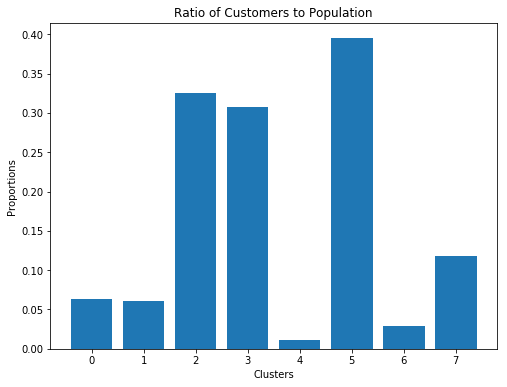

In [ ]:
cluster_df['Proportions'] = cluster_df['Customers'] / cluster_df['Population']

fig, ax = plt.subplots(1, 1, figsize = (8, 6))
ax.bar(cluster_df['Clusters'], cluster_df['Proportions'])
ax.set_xlabel("Clusters")
ax.set_ylabel("Proportions")
ax.set_title("Ratio of Customers to Population")
plt.show()

**Now Let's find the proportions of customers as well as population in each cluster**

In [ ]:
cluster_df['Customers_Prop'] = (cluster_df['Customers'] / cluster_df['Customers'].sum() * 100).round(2)
cluster_df['Population_Prop'] = (cluster_df['Population'] / cluster_df['Population'].sum() * 100).round(2)

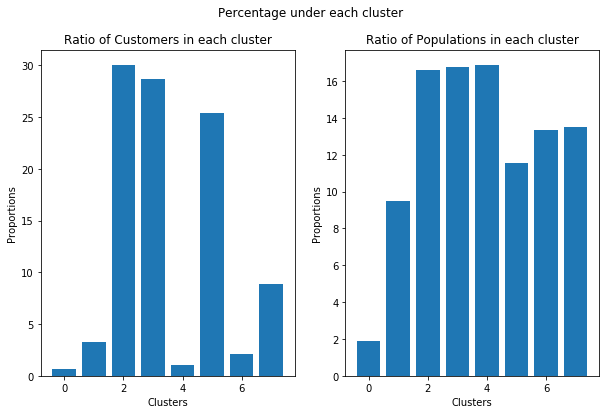

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 6))

ax1.bar(cluster_df['Clusters'], cluster_df['Customers_Prop'])
ax1.set_xlabel("Clusters")
ax1.set_ylabel("Proportions")
ax1.set_title("Ratio of Customers in each cluster")

ax2.bar(cluster_df['Clusters'], cluster_df['Population_Prop'])
ax2.set_xlabel("Clusters")
ax2.set_ylabel("Proportions")
ax2.set_title("Ratio of Populations in each cluster")

fig.suptitle("Percentage under each cluster")
plt.show()

**From above we can see that majority of the customers are lying in Clusters - 2, 3, 7 Whereas cluster 0 and 4 are most under-represented.**

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
mailout_train.shape

(42962, 367)

In [ ]:
labels = mailout_train["RESPONSE"]
mailout_train_LNR = mailout_train["LNR"]

**Cleaning the mailout_train data by creating a function with all the steps followed above for data cleaning**

In [ ]:
def clean_data(azdias, df, attri_values):
    '''Cleaning the dataframe'''
    
    print("Cleaning Given Dataframes")

    start = time.time()


    #We can use Forward Fill method to fill Nan values in Attribute column
    attri_values['Attribute'] = attri_values['Attribute'].ffill()

    # Fixing columns 18 and 19
    print("\tFixing 19, 20 columns")
    Warning_Cols = list(df.columns[19:21])

    df = clear_warn(df)

    print("\tFixing LP_* columns")
    df = fix_LP_cols(df)

    #Replacing the unknown values in the dataset to NaN values
    print("\tReplacing 'unkown' values with 'NaN'")
    unkown_attri_values = attri_values[attri_values["Meaning"] == "unknown"]
    df = replace_unknown(df, unknown_attri_values)

    #Fixing dtypes = 'obejct'
    print("\tFixing object dtypes")
    df = fix_cam_deu(df)

    df = fix_OST(df)

    df.drop('D19_LETZTER_KAUF_BRANCHE', axis = 1, inplace = True)

    df = fix_EINGEFUEFGT(df)

    df = fix_ANDREDE(df)

    df = fix_WOHNLAGE(df)

    #Dropping the ID of the people (LNR)
    print("\tDropping columns not available in azdias")
    cols_drop = [col for col in df.columns if col not in azdias.columns]
    df = df.drop(cols_drop, axis = 1)

    #Imputing the NaN values
    print("\tImputing NaN values")
    df = pd.DataFrame(imputer.fit_transform(df), columns = df.columns)

    #Scaling the data
    print("\tScaling the cleaned data")
    df = pd.DataFrame(scale.fit_transform(df), columns = df.columns)


    end = time.time()
    print (f"Completed Cleaning in {end-start} seconds")

    return df

In [ ]:
mailout_train = clean_data(azdias, mailout_train, attri_values)

Cleaning Given Dataframes
	Fixing 19, 20 columns
	Fixing LP_* columns
	Replacing 'unkown' values with 'NaN'
	Fixing object dtypes
	Dropping columns not available in azdias
	Imputing NaN values
	Scaling the cleaned data
Completed Cleaning in 12.52061676979065 seconds


In [ ]:
print(mailout_train.shape)
print(azdias.shape)

(42962, 359)
(751331, 359)


**We will first train the model with Logistic regression and then setting it as a benchmark performance we'll try different algorithm to improve our model.**

In [ ]:
#Splitting the dataset in Train and Test dataset
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(mailout_train, labels, test_size=0.20, random_state = 101)

In [ ]:
lr = LogisticRegression(random_state = 101) #Initialize the Logistic regression model

In [ ]:
lr.fit(X_train, y_train) #fitting the model.

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=101, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Some people use predict() after creating a logistic regression model. Sklearn's function predict() only returns 0's and 1's. In this competition, the metric is AUC. You will score a higher AUC if you submit probabilities like 0.2, 0.6, 0.8, etc. Therefore after building your logistic regression model (or whatever model), use predict_proba()[:,1] which returns probabilities.

In [ ]:
pred = lr.predict_proba(X_val)[:, 1]
print ("Benchmark ROC-AUC Score: ", roc_auc_score(y_val, pred))

Benchmark ROC-AUC Score:  0.64116681389


BenchMark ROC-AUC score is 0.64. We need to improve on this score

**Let's try different Classification Algorithms to improve on our benchmark score. We will create a Pipeline for all the algorithms and a function to expedtite our process.**

In [ ]:
def train_and_predict(model, X_train, X_val, y_train, y_val):
    """
    Fit a model on X_train, y_train
    predicts on X_val, y_val 
    Calculate AUC-ROC on predictions made on test data
    
    Outputs - AUC - ROC score, and total time taken for training and prediction    
    """
    start = time.time()
    model = model.fit(X_train, y_train)
    
    roc_score = roc_auc_score(y_val, model.predict_proba(X_val)[:,1])
    
    end = time.time()
    time_elapsed = end - start
    
    return roc_score, time_elapsed  

In [ ]:
models = [("LogisticRegression", LogisticRegression(random_state=101)),
         ("DecisionTreeClassifier", DecisionTreeClassifier(random_state=101)),
         ("RandomForestClassifier", RandomForestClassifier(random_state=101)),
         ("GradientBoostingClassifier", GradientBoostingClassifier(random_state=101)),
         ("AdaBoostClassifier", AdaBoostClassifier(random_state=101))]

In [ ]:
results = {"Model":[],
          "AUCROC_score":[],
          "Time_in_sec":[]}

for name, model in models:
    roc, time_ = train_and_predict(model, X_train, X_val, y_train, y_val)
    results["Model"].append(name)
    results["AUCROC_score"].append(roc)
    results["Time_in_sec"].append(time_)

In [ ]:
results = pd.DataFrame.from_dict(results, orient='index').transpose()
results

,Model,AUCROC_score,Time_in_sec
0,LogisticRegression,0.641167,13.8497
1,DecisionTreeClassifier,0.508501,3.95096
2,RandomForestClassifier,0.499958,1.41292
3,GradientBoostingClassifier,0.761534,44.2233
4,AdaBoostClassifier,0.720416,14.5091


Going from the result, we find that **Gradient Boosting Classifier** is the best model, however, it was the slowest of the lot for training. The second best is **AdaBoost Classifier** and it took lesser time. We will tune only on **AdaBoost Classifier** model and check for any improvements. 

But, before going for Hyper-Parameters Tuning, let's run the decomposition in our data and see if it improves our results.

In [ ]:
mailout_train_decom = pca.transform(mailout_train)

In [ ]:
X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(mailout_train_decom, labels, test_size=0.20, random_state = 101)

In [ ]:
results_decom = {"Model":[],
          "AUCROC_score":[],
          "Time_in_sec":[]}

for name, model in models:
    roc, time_ = train_and_predict(model, X_train_1, X_val_1, y_train_1, y_val_1)
    results_decom["Model"].append(name)
    results_decom["AUCROC_score"].append(roc)
    results_decom["Time_in_sec"].append(time_)

In [ ]:
results_decom = pd.DataFrame.from_dict(results_decom, orient='index').transpose()
results_decom

,Model,AUCROC_score,Time_in_sec
0,LogisticRegression,0.64117,13.8756
1,DecisionTreeClassifier,0.493383,114.099
2,RandomForestClassifier,0.486894,20.4021
3,GradientBoostingClassifier,0.584873,157.743
4,AdaBoostClassifier,0.581564,95.9342


Decomposition of our data into reduced dimension only worsens our score. We will continue with our original data set.

Let's do the tuning with **GRID SEARCH**

**Grid Search - AdaBoostClassifier**

In [ ]:
adaboost_grid.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__algorithm', 'estimator__base_estimator', 'estimator__learning_rate', 'estimator__n_estimators', 'estimator__random_state', 'estimator', 'fit_params', 'iid', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])

In [ ]:
param_grid = {"n_estimators": [50,100,150],
              "learning_rate": [0.01,0.1,0.5,1],
              "algorithm":["SAMME.R"]
              }

adaboost_grid = GridSearchCV(estimator = AdaBoostClassifier(random_state=101), 
                           param_grid = param_grid, 
                           scoring = "roc_auc", 
                           cv = 5, n_jobs = -1, verbose=1)

In [ ]:
%%time
adaboost_grid.fit(X_train, y_train)

adaboost = adaboost_grid.best_estimator_

print("Best Score: ", adaboost_grid.best_score_)
print("Best Params: ", adaboost_grid.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 22.9min finished


Best Score:  0.763539228708
Best Params:  {'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 50}
CPU times: user 23min 5s, sys: 0 ns, total: 23min 5s
Wall time: 23min 8s


In [ ]:
preds_adaboost = adaboost.predict_proba(X_val)[:,1]

ROC_Adaboost = roc_auc_score(y_val, preds_adaboost)

print("ROC score on validation data: ", ROC_Adaboost)

ROC score on validation data:  0.771612052936


Even though our model showed quite good improvement on its performance, however it could be further improved by performing more tuning on our hyper parameters by including more values for the parameters specified on the Grid Search method applied or adding more hyper parameters. We could have also tested more models at the beginning of the process in order to see if its AUC value was higher than in the case of Gradient Boosting.

# **Part 3: Kaggle Competition**

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link here, you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')#Loading the test data

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [ ]:
mailout_test_LNR = mailout_test["LNR"] #

In [ ]:
mailout_test = clean_data(azdias, mailout_test, attri_values) #Cleaning the test dataset

Cleaning Given Dataframes
	Fixing 19, 20 columns
	Fixing LP_* columns
	Replacing 'unkown' values with 'NaN'
	Fixing object dtypes
	Dropping columns not available in azdias
	Imputing NaN values
	Scaling the cleaned data
Completed Cleaning in 10.094944953918457 seconds


In [ ]:
preds_test_adaboost = adaboost.predict_proba(mailout_test)[:,1] #Using Adaboost in our Test data

kaggle_adaboost = pd.DataFrame(index=mailout_test_LNR, data=preds_test_adaboost)
kaggle_adaboost.rename(columns={0: "RESPONSE"}, inplace=True)


kaggle_adaboost.head()

,RESPONSE
LNR,
1754,0.320128
1770,0.325810
1465,0.247589
1470,0.248562
1478,0.255703


In [ ]:
# Save file to submit
kaggle_adaboost.to_csv('Submission.csv')